In [1]:
# Plot 2d NLL loss surface for  binary logistic regression with 1 feature
# Loosely based on
# https://peterroelants.github.io/posts/neural-network-implementation-part02/

import jax
import jax.numpy as jnp
from jax.config import config

import matplotlib.pyplot as plt
import seaborn as sns

try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

from probml_utils import LogisticRegression as lr

from mpl_toolkits.mplot3d import axes3d, Axes3D

try:
    import sklearn
except ModuleNotFoundError:
    %pip install -qq scikit-learn
    import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import datasets

In [2]:
config.update("jax_enable_x64", True)

In [4]:
iris = datasets.load_iris()

X = iris["data"][:, 3:]  # petal width
y = (iris["target"] == 2).astype("int64")  # 1 if Iris-Virginica, else 0
print(X.shape)
log_reg = LogisticRegression(solver="lbfgs", fit_intercept=True, penalty="none")
log_reg.fit(X, y)

w_mle = log_reg.coef_[0][0]  # 12.947270212450366
b_mle = log_reg.intercept_[0]  # -21.125250539711022
ypred = log_reg.predict_proba(X)


# Probml_utils Logistic Regression
parameters, b_mle1, w_mle1 = lr.fit(X, y, lambd=0)

ypred1 = lr.predict_proba(parameters, X)

assert jnp.isclose(w_mle, w_mle1[0], rtol=1e-4)
assert jnp.isclose(b_mle, b_mle1, rtol=1e-4)
assert jnp.isclose(ypred[0][1], ypred1[0])


# Define the logistic function
def logistic(z):
    return 1.0 / (1 + jnp.exp(-z))


# Define the prediction function
@jax.jit
def predict_prob(x, w):
    z = x.dot(w.T)
    return logistic(z)


# Define the NLL loss function (y=probability, t=binary target)
@jax.jit
def loss(p, y):
    return -jnp.mean(jnp.multiply(y, jnp.log(p)) + jnp.multiply((1 - y), jnp.log(1 - p)))


N = X.shape[0]
ones = jnp.ones((N, 1))
X1 = jnp.hstack((X, ones))

# We compute the loss on a grid of (w, b) values.
# We use for loops for simplicity.
ngrid = 50
sf = 0.5
ws = jnp.linspace(-sf * w_mle, +sf * w_mle, ngrid)
bs = jnp.linspace(-sf * b_mle, +sf * b_mle, ngrid)
grid_w, grid_b = jnp.meshgrid(ws, bs)
loss_grid = []
for i in range(ngrid):
    losses = []
    for j in range(ngrid):
        params = jnp.array([[grid_w[i, j], grid_b[i, j]]])
        p = predict_prob(X1, params)
        losses.append(loss(p, y))
    loss_grid.append(losses)

loss_grid = jnp.array(loss_grid)

(150, 1)


/home/rohit_khoiwal/anaconda3/envs/gpu_env/lib/python3.8/site-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


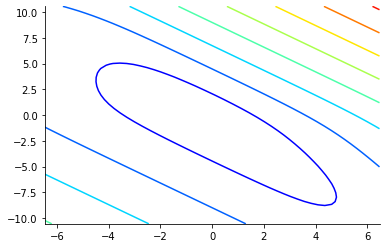

In [5]:
fig, ax = plt.subplots()
CS = plt.contour(grid_w, grid_b, loss_grid, cmap="jet")
pml.savefig("logregIrisLossContours")
sns.despine()
plt.show()

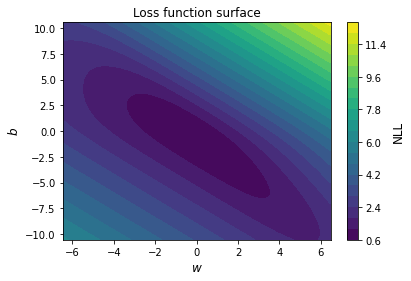

In [6]:
# Plot the loss function surface
plt.figure()
plt.contourf(grid_w, grid_b, loss_grid, 20)
cbar = plt.colorbar()
cbar.ax.set_ylabel("NLL", fontsize=12)
plt.xlabel("$w$", fontsize=12)
plt.ylabel("$b$", fontsize=12)
plt.title("Loss function surface")
pml.savefig("logregIrisLossHeatmap")
plt.show()

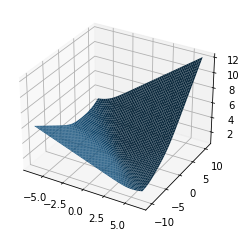

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(grid_w, grid_b, loss_grid)
pml.savefig("logregIrisLossSurf")
plt.show()